In [0]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/THI'

In [4]:
import pandas as pd
emotion = pd.read_csv(path + '/emotion.csv')
emotion.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
import numpy as np
def reshape_string_listofnumber(df, index):
  string = df[index]
  string = string.split(' ')
  lst = np.array([int(charac) for charac in string])

  return lst

def reshape_dataset_matrix(df):
  matrix = np.empty((df.shape[0], 48, 48, 1))
  for i in range(df.shape[0]):
    ele = reshape_string_listofnumber(df, i)
    ele = np.reshape(ele,(48,48,1))
    matrix[i] = ele

  return matrix

In [0]:
x_train = emotion.pixels[emotion.Usage == 'Training']
x_test = emotion.pixels[emotion.Usage == 'PrivateTest'].reset_index(drop = True)

x_train = reshape_dataset_matrix(x_train)
x_test = reshape_dataset_matrix(x_test)

In [0]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [9]:
from keras.models import Model
from keras.layers import (Input, Conv2D, MaxPool2D, UpSampling2D, LeakyReLU)

Using TensorFlow backend.


In [0]:
def denoise(features_shape, act = 'relu'):
  x = Input(name = 'inputs', shape = features_shape, dtype = 'float32')
  o = x

  o = Conv2D(32, (3,3), activation=act, padding='same', strides = (1,1))(o)
  o = MaxPool2D((2,2), strides=(2,2), padding='same')(o)
  o = Conv2D(32, (3,3), activation=act, padding='same', strides=(1,1))(o)
  enc = MaxPool2D((2,2), strides=(2,2), padding='same')(o)

  o = Conv2D(32, (3,3), activation=act, padding='same', strides=(1,1))(enc)
  o = UpSampling2D((2,2))(o)
  o = Conv2D(32, (3,3), activation=act, padding='same', strides=(1,1))(o)
  o = UpSampling2D((2,2))(o)
  dec = Conv2D(1, (3,3), activation='sigmoid', padding='same', strides=(1,1))(o)

  Model(input=x, outputs=dec).summary()
  return Model(input=x, outputs=dec)

In [11]:
batch_size = 128
epochs = 40

autoencoder = denoise((48,48,1), act = LeakyReLU(alpha=0.1))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)       

In [12]:
autoencoder.fit(x_train_noisy, x_train_noisy, epochs = epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test_noisy, x_test_noisy))




Train on 28709 samples, validate on 3589 samples
Epoch 1/40





28709/28709 [==============================] - 17s 607us/step - loss: 0.6236 - val_loss: 0.6012
Epoch 2/40
28709/28709 [==============================] - 9s 305us/step - loss: 0.5997 - val_loss: 0.5963
Epoch 3/40
28709/28709 [==============================] - 9s 320us/step - loss: 0.5943 - val_loss: 0.5913
Epoch 4/40
28709/28709 [==============================] - 9s 308us/step - loss: 0.5909 - val_loss: 0.5887
Epoch 5/40
28709/28709 [==============================] - 9s 308us/step - loss: 0.5884 - val_loss: 0.5856
Epoch 6/40
28709/28709 [==============================] - 9s 307us/step - loss: 0.5863 - val_loss: 0.5856
Epoch 7/40
28709/28709 [==============================] - 9s 308us/step - loss: 0.5848 - val_loss: 0.5840
Epoch 8/40
28709/28709 [==============================] - 9s 310us/step - loss: 0.5835 - val_loss: 0.5830
Epoch 9/40
28709/28709 [==============================] - 9s 310us/step - loss: 0.5822 - val_l

In [0]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
import keras 

num_images = 10

np.random.seed(42)
random_test_images = np.random.randint(x_test_noisy.shape[0], size = num_images)

autoencode_imgs = autoencoder.predict(x_test_noisy)

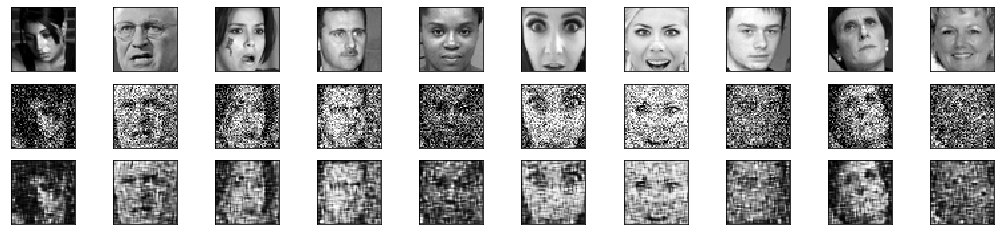

In [17]:
plt.figure(figsize = (18, 4))

for i, image_idx in enumerate(random_test_images):
  # Original images:
  ax = plt.subplot(3, num_images, i+1)
  plt.imshow(x_test[image_idx].reshape(48,48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Images with noise:
  ax = plt.subplot(3, num_images, num_images+i+1)
  plt.imshow(x_test_noisy[image_idx].reshape(48,48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Images after denoising
  ax = plt.subplot(3, num_images, 2*num_images+i+1)
  plt.imshow(autoencode_imgs[image_idx].reshape(48,48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

==> The result may be accepted. Obviously, the third line is better than the second line which was added noise before, so if we do not have any solution for noise dataset like line 2, we can use line 3 instead.